In [1]:
from numpy.ma.core import shape
from torchsummary import summary
from torch import nn
import torch

from loss.loss_function import get_loss_function
from models.SFMCNN import SFMCNN
from models.RGB_SFMCNN import RGB_SFMCNN
from models.RGB_SFMCNN_V2 import RGB_SFMCNN_V2
from dataloader import get_dataloader
from config import *


from monitor.monitor_method import get_all_layers_stats
from monitor.plot_df import json_to_table, save_table_as_image, plot_heatmap
from monitor.plot_monitor import plot_all_layers_graph

with torch.no_grad():
    # Load Dataset
    train_dataloader, test_dataloader = get_dataloader(dataset=config['dataset'], root=config['root'] + '/data/',
                                                       batch_size=config['batch_size'],
                                                       input_size=config['input_shape'])
    images, labels = torch.tensor([]), torch.tensor([])
    for batch in train_dataloader:
        imgs, lbls = batch
        images = torch.cat((images, imgs))
        labels = torch.cat((labels, lbls))
    print(images.shape, labels.shape)

    # Load Model
    models = {'SFMCNN': SFMCNN, 'RGB_SFMCNN': RGB_SFMCNN, 'RGB_SFMCNN_V2': RGB_SFMCNN_V2}
    checkpoint_filename = 'RGB_SFMCNN_V2_best'
    checkpoint = torch.load(f'./pth/{config["dataset"]}_pth/{checkpoint_filename}.pth', weights_only=True)
    model = models[arch['name']](**dict(config['model']['args']))
    model.load_state_dict(checkpoint['model_weights'])
    model.cpu()
    model.eval()
    summary(model, input_size=(config['model']['args']['in_channels'], *config['input_shape']), device='cpu')
    print(model)

    # Test Model
    batch_num = 1000
    pred = model(images[:batch_num])
    y = labels[:batch_num]
    correct = (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    print("Test Accuracy: " + str(correct / len(pred)))

    loss_fn = get_loss_function(config['loss_fn'])
    loss = loss_fn(pred, y)
    # input()

Code/runs/train/exp
torch.Size([60000, 3, 28, 28]) torch.Size([60000, 30])
triangle
cReLU_percent
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        RGB_Conv2d-1             [-1, 30, 6, 6]               0
        RGB_Conv2d-2             [-1, 30, 6, 6]               0
          triangle-3             [-1, 30, 6, 6]               0
          triangle-4             [-1, 30, 6, 6]               0
     cReLU_percent-5             [-1, 30, 6, 6]               0
     cReLU_percent-6             [-1, 30, 6, 6]               0
               SFM-7             [-1, 30, 3, 6]               0
        RBF_Conv2d-8            [-1, 225, 3, 6]           6,750
     cReLU_percent-9            [-1, 225, 3, 6]               0
              SFM-10            [-1, 225, 3, 3]               0
       RBF_Conv2d-11            [-1, 625, 3, 3]         140,625
    cReLU_percent-12            [-1, 625, 3, 3]               0
     

In [33]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import transforms

from pytorch_grad_cam import run_dff_on_image, GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np
import cv2
import torch
from typing import List, Callable, Optional




""" Model wrapper to return a tensor"""
class HuggingfaceToTensorModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(HuggingfaceToTensorModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        y = self.model(x)
        return self.model(x)


class SimilarityToConceptTarget:
    def __init__(self, features):
        self.features = features
    
    def __call__(self, model_output):
        cos = torch.nn.CosineSimilarity(dim=0)
        print("model_output: ", model_output.shape)
        print("self.features: ", self.features.shape)
        print("cos: ", cos(model_output, self.features))
        return cos(model_output, self.features)


""" Translate the category name to the category index.
    Some models aren't trained on Imagenet but on even larger datasets,
    so we can't just assume that 761 will always be remote-control.

"""
def category_name_to_index(model, category_name):
    name_to_index = dict((v, k) for k, v in model.config.id2label.items())
    return name_to_index[category_name]
    
""" Helper function to run GradCAM on an image and create a visualization.
    (note to myself: this is probably useful enough to move into the package)
    If several targets are passed in targets_for_gradcam,
    e.g different categories,
    a visualization for each of them will be created.
    
"""
def run_grad_cam_on_image(model: torch.nn.Module,
                          target_layer: torch.nn.Module,
                          targets_for_gradcam: List[Callable],
                          reshape_transform: Optional[Callable],
                          input_tensor: torch.nn.Module,
                          input_image: Image,
                          method: Callable=GradCAM):
    with method(model=HuggingfaceToTensorModelWrapper(model),
                 target_layers=[target_layer],
                 reshape_transform=reshape_transform) as cam:

        # Replicate the tensor for each of the categories we want to create Grad-CAM for:
        repeated_tensor = input_tensor[None, :].repeat(len(targets_for_gradcam), 1, 1, 1)
        
        batch_results = cam(input_tensor=repeated_tensor,
                            targets=targets_for_gradcam)
        

        results = []
        for grayscale_cam in batch_results:
            visualization = show_cam_on_image(np.float32(input_image)/255,
                                              grayscale_cam,
                                              use_rgb=True)
            # Make it weight less in the notebook:
            visualization = cv2.resize(visualization,
                                       (visualization.shape[1] * 2, visualization.shape[0] * 2))
            results.append(visualization)
        return np.hstack(results)
    
    
def print_top_categories(model, img_tensor, top_k=5):
    logits = model(img_tensor.unsqueeze(0))
    indices = logits.cpu()[0, :].detach().numpy().argsort()[-top_k :][::-1]
    print(f"logit : {logits}")
    print(f"indices : {indices}")
    # for i in indices:
    #     print(f"Predicted class {i}: {model.config.id2label[i]}")
    
def get_max_index(model, img_tensor, top_k=5):
    logits = model(img_tensor.unsqueeze(0))
    indices = logits.cpu()[0, :].detach().numpy().argsort()[-top_k :][::-1]
    # print(f"logit : {logits}")
    # print(f"indices : {indices}")
    # 
    return indices[0]

def show_all_heatmap(model, img_tensor, index = -1):
    if index == -1:
        index = get_max_index(model, img_tensor)
    print(f"index : {index}" )
    targets_for_gradcam = [ClassifierOutputTarget(index)]
    
    
    for layer in layers:
        print(f"Layer: {layer}")
        target_layer = layers[layer]
        
        cam_img = run_grad_cam_on_image(model=model,
                              target_layer=target_layer,
                              targets_for_gradcam=targets_for_gradcam,
                              reshape_transform=None,
                                         input_tensor=img_tensor,
                                         input_image=image)
        
        display(Image.fromarray(cam_img))

In [6]:
device = 'cpu'
layers = {}
layers['RGB_convs_0'] = model.RGB_convs[1]  # 空間合併前
# 
layers['RGB_convs_1'] = model.RGB_convs[2][1]  # 空間合併前

layers['RGB_convs_2'] = model.RGB_convs[3]

layers['Gray_convs_0'] = model.Gray_convs[0][1]
# 
layers['Gray_convs_1'] = model.Gray_convs[2][1]  # 空間合併前

layers['Gray_convs_2'] = model.Gray_convs[3]

layers


{'RGB_convs_0': SFM(
   filter=(2, 1), alpha=[[0.99]
    [0.9 ]]
 ),
 'RGB_convs_1': cReLU_percent(percent=0.4000000059604645),
 'RGB_convs_2': Sequential(
   (0): RBF_Conv2d(initial = kaiming, weight shape = (625, 225, 1, 1))
   (1): cReLU_percent(percent=0.5)
 ),
 'Gray_convs_0': cReLU_percent(percent=0.30000001192092896),
 'Gray_convs_1': cReLU_percent(percent=0.4000000059604645),
 'Gray_convs_2': Sequential(
   (0): RBF_Conv2d(initial = kaiming, weight shape = (1225, 625, 1, 1))
   (1): cReLU_percent(percent=0.5)
 )}

logit : tensor([[ 18.6729, -40.8763,   5.2983, -24.2325, -30.0623, -35.8662,  -0.9524,
         -19.5898, -30.3936, -12.7920,  -5.9715, -80.3550, -27.6583, -55.3454,
         -43.4096, -69.0840, -31.2406, -61.7927, -51.7227, -49.4445, -11.8581,
         -71.7809, -29.3594, -47.7584, -51.4586, -67.0915, -38.5866, -53.5844,
         -61.1280, -44.3852]], grad_fn=<AddmmBackward0>)
indices : [ 0  2  6 10 20]
index : 0
Layer: RGB_convs_0


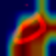

Layer: RGB_convs_1


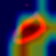

Layer: RGB_convs_2


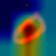

Layer: Gray_convs_0


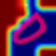

Layer: Gray_convs_1


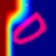

Layer: Gray_convs_2


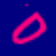

logit : tensor([[-49.7007, -39.1684, -30.6660, -31.7561, -56.7170, -83.2386, -71.8786,
          -9.5491, -39.8805, -39.2960, -48.6323, -39.3107, -33.7352, -30.4826,
         -63.9484, -86.1598, -82.2782,  -6.9264, -47.9769, -47.3483, -29.9546,
         -28.4581, -15.9851,  -4.8178, -49.5700, -67.3713, -64.2431,  10.3463,
         -34.3983, -29.3469]], grad_fn=<AddmmBackward0>)
indices : [27 23 17  7 22]
index : 27
Layer: RGB_convs_0


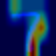

Layer: RGB_convs_1


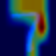

Layer: RGB_convs_2


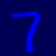

Layer: Gray_convs_0


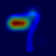

Layer: Gray_convs_1


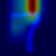

Layer: Gray_convs_2


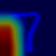

logit : tensor([[ -66.3379,  -67.8800,  -40.0294,  -39.8701,  -78.2298,  -77.5818,
         -110.5865,   -7.2861,  -64.4257,  -52.6505,  -63.8222,  -73.0636,
          -45.4389,  -31.4543,  -57.6969,  -73.5909, -111.8834,   -2.7741,
          -64.3334,  -45.8104,  -38.7665,  -37.1066,   -9.4307,  -10.5114,
          -36.2491,  -60.1455,  -92.7407,   22.3009,  -48.9087,  -32.3853]],
       grad_fn=<AddmmBackward0>)
indices : [27 17  7 22 23]
index : 27
Layer: RGB_convs_0


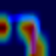

Layer: RGB_convs_1


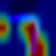

Layer: RGB_convs_2


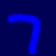

Layer: Gray_convs_0


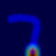

Layer: Gray_convs_1


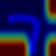

Layer: Gray_convs_2


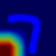

logit : tensor([[-61.3109, -48.1159, -24.0471, -49.9210, -69.0890, -96.4456, -71.4671,
         -60.6152, -55.2568, -90.5457, -29.6095, -31.7850,  16.9271, -10.9055,
         -37.1141, -59.3716, -47.7548, -26.4997, -33.3960, -52.7088, -53.9620,
         -40.9695,  -9.4940, -52.9745, -61.3431, -88.8577, -67.4655, -51.2423,
         -54.7397, -84.9776]], grad_fn=<AddmmBackward0>)
indices : [12 22 13  2 17]
index : 12
Layer: RGB_convs_0


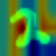

Layer: RGB_convs_1


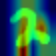

Layer: RGB_convs_2


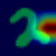

Layer: Gray_convs_0


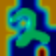

Layer: Gray_convs_1


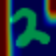

Layer: Gray_convs_2


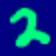

logit : tensor([[-39.3417, -23.6819, -43.0551, -43.2296,  30.0617, -29.3882, -28.9183,
           2.0149, -18.8090,  -5.0249, -63.6383, -62.6982, -64.5295, -66.4237,
           6.5877, -64.4005, -64.8729, -39.1628, -42.3336, -33.2672, -58.6582,
         -62.7220, -67.2260, -54.7038,  -3.2701, -63.7484, -70.6257, -34.5611,
         -41.2843, -27.7016]], grad_fn=<AddmmBackward0>)
indices : [ 4 14  7 24  9]
index : 4
Layer: RGB_convs_0


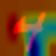

Layer: RGB_convs_1


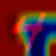

Layer: RGB_convs_2


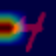

Layer: Gray_convs_0


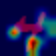

Layer: Gray_convs_1


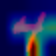

Layer: Gray_convs_2


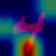

In [39]:
for i in range(0, 5):

    image = images[i]
    # 将 torch.Tensor 转换为 PIL Image
    image = transforms.ToPILImage()(image)
    img_tensor = transforms.ToTensor()(image)
    
    display(image)
    
    show_all_heatmap(model, img_tensor)



In [81]:
 model.Gray_convs

Sequential(
  (0): Sequential(
    (0): Gray_Conv2d(initial = kaiming, weight shape = (70, 1, 5, 5))
    (1): cReLU_percent(percent=0.30000001192092896)
  )
  (1): SFM(
    filter=(2, 2), alpha=[[0.99 0.96]
     [0.93 0.9 ]]
  )
  (2): Sequential(
    (0): RBF_Conv2d(initial = kaiming, weight shape = (625, 70, 1, 1))
    (1): cReLU_percent(percent=0.4000000059604645)
    (2): SFM(filter=(1, 3), alpha=[[0.99  0.945 0.9  ]])
  )
  (3): Sequential(
    (0): RBF_Conv2d(initial = kaiming, weight shape = (1225, 625, 1, 1))
    (1): cReLU_percent(percent=0.5)
  )
)

In [82]:
model.RGB_convs

Sequential(
  (0): Sequential(
    (0): RGB_Conv2d(initial = uniform, weight shape = torch.Size([30, 3]), cal_dist = LAB)
    (1): triangle(w = 1.0)
    (2): cReLU_percent(percent=0.30000001192092896)
  )
  (1): SFM(
    filter=(2, 2), alpha=[[0.99 0.96]
     [0.93 0.9 ]]
  )
  (2): Sequential(
    (0): RBF_Conv2d(initial = kaiming, weight shape = (225, 30, 1, 1))
    (1): cReLU_percent(percent=0.4000000059604645)
    (2): SFM(filter=(1, 3), alpha=[[0.99  0.945 0.9  ]])
  )
  (3): Sequential(
    (0): RBF_Conv2d(initial = kaiming, weight shape = (625, 225, 1, 1))
    (1): cReLU_percent(percent=0.5)
  )
)